In [336]:
# Load dependencies
import pandas as pd
import numpy as np

import seaborn as sns

# Perform multiple imputation for missing values 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter

# Train / Test split
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [337]:
dfs = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/combined_other_datasets_for_modeling.csv')
df = dfs.copy()
df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals


In [338]:
df.shape

(1678, 13)

In [339]:
df.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Sex', 'Onset_site',
       'Study_Arm', 'European', 'Age', 'Diagnostic_Delay', 'Disease_Duration',
       'TRICALS', 'Study_id', 'Expt'],
      dtype='object')

In [340]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1678 entries, 0 to 1677
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        1678 non-null   object 
 1   Event             1678 non-null   float64
 2   Vital_capacity    1678 non-null   float64
 3   Sex               1678 non-null   object 
 4   Onset_site        1678 non-null   object 
 5   Study_Arm         1678 non-null   object 
 6   European          1678 non-null   int64  
 7   Age               1678 non-null   float64
 8   Diagnostic_Delay  1678 non-null   float64
 9   Disease_Duration  1678 non-null   float64
 10  TRICALS           1678 non-null   float64
 11  Study_id          1678 non-null   object 
 12  Expt              1678 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 170.6+ KB


In [341]:
print(f"Expt: {df['Expt'].value_counts().to_dict()}\n")
print(f"Study_id: {df['Study_id'].value_counts().to_dict()}")

Expt: {'riluzole': 1282, 'mirocals': 220, 'licals': 176}

Study_id: {'301': 959, 'miro': 220, 'lica': 176, '302': 168, '216': 155}


In [342]:
df = df[df['Study_id'] == '301']
print(f"Expt: {df['Expt'].value_counts().to_dict()}\n")
print(f"Study_id: {df['Study_id'].value_counts().to_dict()}")

df.shape

Expt: {'riluzole': 959}

Study_id: {'301': 959}


(959, 13)

In [343]:
df['Agec'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
df['TRICALSc'] = (df['TRICALS'] - df['TRICALS'].mean()) / df['TRICALS'].std()

In [344]:
df_time = df[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']]
df_time.describe()
# df_time.isna().sum()

,Disease_Duration,Diagnostic_Delay,Vital_capacity
count,959.000000,959.000000,959.000000
mean,14.060687,0.120718,88.194115
std,5.197803,0.256259,18.852816
min,0.164258,-0.919842,44.117647
25%,11.005256,0.000000,73.137508
50%,16.097240,0.000000,85.397096
75%,18.035480,0.131406,101.847412
max,22.667543,2.036794,157.367668


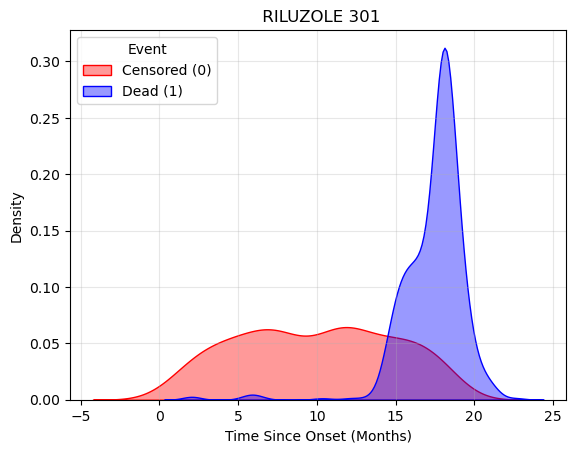

<Figure size 400x300 with 0 Axes>

In [345]:
# Plot distribution of survival time for both groups
sns.kdeplot(
    data=df, x="Disease_Duration", hue="Event",
    fill=True, common_norm=False, alpha=0.4,
    palette={1: "red", 0: "blue"},
);

plt.xlabel("Time Since Onset (Months)")
plt.ylabel("Density")
plt.title(" RILUZOLE 301")
plt.legend(title="Event", labels=["Censored (0)", "Dead (1)"])
plt.grid(alpha=0.3)
plt.show();

plt.figure(figsize=(4,3));

In [346]:
df['Disease_Durationc'] = np.log1p(df['Disease_Duration']) # ln(1 + x)
df['Diagnostic_Delayc'] = np.log1p(df['Diagnostic_Delay']) # ln(1 + x)
df['Vital_capacityc'] = np.log(df['Vital_capacity']) # ln(x)

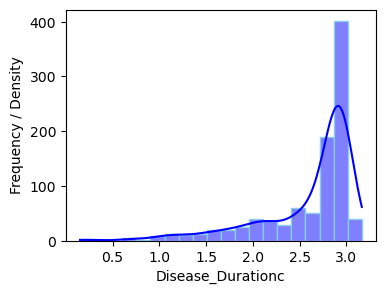

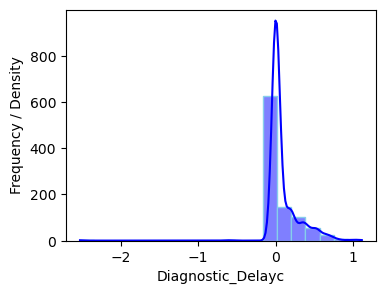

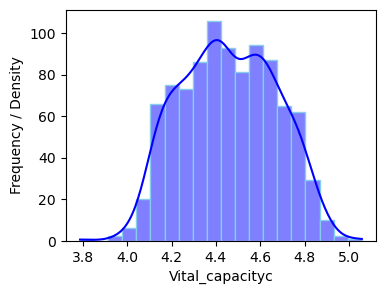

In [347]:
df_time = df[['Disease_Durationc', 'Diagnostic_Delayc', 'Vital_capacityc']]
df_time.describe()

import seaborn as sns
# Plot histogram and density
for col in df_time.columns:
    plt.figure(figsize=(4,3))
    sns.histplot(df[col], bins=20, kde=True, color='blue', edgecolor='skyblue')
    plt.ylabel('Frequency / Density')
    plt.show()

In [348]:
df.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Sex', 'Onset_site',
       'Study_Arm', 'European', 'Age', 'Diagnostic_Delay', 'Disease_Duration',
       'TRICALS', 'Study_id', 'Expt', 'Agec', 'TRICALSc', 'Disease_Durationc',
       'Diagnostic_Delayc', 'Vital_capacityc'],
      dtype='object')

In [349]:
df['European'] = df['European'].astype('int')
df['Event'] = df['Event'].astype('int')

In [350]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 959 entries, 551 to 1509
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         959 non-null    object 
 1   Event              959 non-null    int64  
 2   Vital_capacity     959 non-null    float64
 3   Sex                959 non-null    object 
 4   Onset_site         959 non-null    object 
 5   Study_Arm          959 non-null    object 
 6   European           959 non-null    int64  
 7   Age                959 non-null    float64
 8   Diagnostic_Delay   959 non-null    float64
 9   Disease_Duration   959 non-null    float64
 10  TRICALS            959 non-null    float64
 11  Study_id           959 non-null    object 
 12  Expt               959 non-null    object 
 13  Agec               959 non-null    float64
 14  TRICALSc           959 non-null    float64
 15  Disease_Durationc  959 non-null    float64
 16  Diagnostic_Delayc  959 non-n

In [351]:
print(df.shape)
df.head(3)

(959, 18)


,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Agec,TRICALSc,Disease_Durationc,Diagnostic_Delayc,Vital_capacityc
551,11001,1,74.619023,1,1.0,ACTIVE,1,64.0,0.229961,7.161629,-1.973438,301,riluzole,0.665206,1.189157,2.099444,0.206982,4.312395
552,11002,0,127.558757,1,1.0,PLACEBO,1,42.0,0.000000,19.152431,-3.891616,301,riluzole,-1.339438,-1.653300,3.003325,0.000000,4.848577
553,11003,1,80.671485,1,1.0,ACTIVE,1,62.0,0.459921,18.232589,-2.340926,301,riluzole,0.482966,0.644593,2.956606,0.378382,4.390385


In [352]:
print(f'Event: {df['Event'].value_counts().to_dict()}\n')
print(f'Expt: {df['Expt'].value_counts().to_dict()}\n')
print(f'Onset_site: {df['Onset_site'].value_counts().to_dict()}\n')
print(f'Sex: {df['Sex'].value_counts().to_dict()}\n')
print(f'Study_Arm: {df['Study_Arm'].value_counts().to_dict()}\n')
print(f'European: {df['European'].value_counts().to_dict()}\n')

Event: {0: 532, 1: 427}

Expt: {'riluzole': 959}

Onset_site: {'1.0': 915, '2.0': 44}

Sex: {'1': 575, '0': 384}

Study_Arm: {'ACTIVE': 717, 'PLACEBO': 242}

European: {1: 938, 2: 8, 3: 6, 4: 6, 5: 1}



In [353]:
mapping = {'Limb': 1, 'Bulbar': 0, 'Other': 1, '1.0': 1,
           '0.0': 0, '2.0': 0, 1.0: 1, 0.0: 0}

df['Onset_site'] = df['Onset_site'].map(mapping)

#________
mapping1 = {'M': 1, 'F': 0, 'Male': 1,'Female': 0, '1': 1, '0': 0}

df['Sex'] = df['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

df['Study_Arm'] = df['Study_Arm'].map(mapping2)

#________
df['European'] = np.where(df['European'] == 1, 1, 0)

In [354]:
print(f'Expt: {df['Expt'].value_counts().to_dict()}\n')
print(f'Onset_site: {df['Onset_site'].value_counts().to_dict()}\n')
print(f'Sex: {df['Sex'].value_counts().to_dict()}\n')
print(f'Study_Arm: {df['Study_Arm'].value_counts().to_dict()}\n')
print(f'European: {df['European'].value_counts().to_dict()}\n')

Expt: {'riluzole': 959}

Onset_site: {1: 915, 0: 44}

Sex: {1: 575, 0: 384}

Study_Arm: {'Active': 717, 'Placebo': 242}

European: {1: 938, 0: 21}



In [355]:
# Identify categorical columns
cat_cols = ['Onset_site', 'European', 'Sex'] #, 'Study_Arm']  # replace with your actual categorical columns

# One-hot encode
df_onehot = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [356]:
df_onehot.head(3)

,subject_id,Event,Vital_capacity,Study_Arm,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Agec,TRICALSc,Disease_Durationc,Diagnostic_Delayc,Vital_capacityc,Onset_site_1,European_1,Sex_1
551,11001,1,74.619023,Active,64.0,0.229961,7.161629,-1.973438,301,riluzole,0.665206,1.189157,2.099444,0.206982,4.312395,True,True,True
552,11002,0,127.558757,Placebo,42.0,0.000000,19.152431,-3.891616,301,riluzole,-1.339438,-1.653300,3.003325,0.000000,4.848577,True,True,True
553,11003,1,80.671485,Active,62.0,0.459921,18.232589,-2.340926,301,riluzole,0.482966,0.644593,2.956606,0.378382,4.390385,True,True,True


In [357]:
df_onehot.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Study_Arm', 'Age',
       'Diagnostic_Delay', 'Disease_Duration', 'TRICALS', 'Study_id', 'Expt',
       'Agec', 'TRICALSc', 'Disease_Durationc', 'Diagnostic_Delayc',
       'Vital_capacityc', 'Onset_site_1', 'European_1', 'Sex_1'],
      dtype='object')

In [358]:
# Convert one-hot encoded columns to int
df_onehot['Onset_site_1'] = df_onehot['Onset_site_1'].astype(int)
df_onehot['European_1'] = df_onehot['European_1'].astype(int)
df_onehot['Sex_1'] = df_onehot['Sex_1'].astype(int)
# df_onehot['Study_Arm_Placebo'] = df_onehot['Study_Arm_Placebo'].astype(int)

In [359]:
df_onehot.head(2)

,subject_id,Event,Vital_capacity,Study_Arm,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Agec,TRICALSc,Disease_Durationc,Diagnostic_Delayc,Vital_capacityc,Onset_site_1,European_1,Sex_1
551,11001,1,74.619023,Active,64.0,0.229961,7.161629,-1.973438,301,riluzole,0.665206,1.189157,2.099444,0.206982,4.312395,1,1,1
552,11002,0,127.558757,Placebo,42.0,0.000000,19.152431,-3.891616,301,riluzole,-1.339438,-1.653300,3.003325,0.000000,4.848577,1,1,1


In [360]:
# Create interactions
df_onehot['Sex (Male) : onset (Limb)'] = df_onehot['Sex_1']*df_onehot['Onset_site_1']
df_onehot['Sex (Male) : Age'] = df_onehot['Sex_1']*df_onehot['Age']
df_onehot['Age : onset (Limb)'] = df_onehot['Age']*df_onehot['Onset_site_1']
df_onehot['Age : TRICALS'] = df_onehot['Age']*df_onehot['TRICALS']
# df_onehot['Trical : Placebo Arm'] = df_onehot['TRICALS']*df_onehot['Study_Arm_Placebo']

In [361]:
df_onehot.head(3)

,subject_id,Event,Vital_capacity,Study_Arm,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Agec,TRICALSc,Disease_Durationc,Diagnostic_Delayc,Vital_capacityc,Onset_site_1,European_1,Sex_1,Sex (Male) : onset (Limb),Sex (Male) : Age,Age : onset (Limb),Age : TRICALS
551,11001,1,74.619023,Active,64.0,0.229961,7.161629,-1.973438,301,riluzole,0.665206,1.189157,2.099444,0.206982,4.312395,1,1,1,1,64.0,64.0,-126.300009
552,11002,0,127.558757,Placebo,42.0,0.000000,19.152431,-3.891616,301,riluzole,-1.339438,-1.653300,3.003325,0.000000,4.848577,1,1,1,1,42.0,42.0,-163.447865
553,11003,1,80.671485,Active,62.0,0.459921,18.232589,-2.340926,301,riluzole,0.482966,0.644593,2.956606,0.378382,4.390385,1,1,1,1,62.0,62.0,-145.137414


In [362]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 959 entries, 551 to 1509
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   subject_id                 959 non-null    object 
 1   Event                      959 non-null    int64  
 2   Vital_capacity             959 non-null    float64
 3   Study_Arm                  959 non-null    object 
 4   Age                        959 non-null    float64
 5   Diagnostic_Delay           959 non-null    float64
 6   Disease_Duration           959 non-null    float64
 7   TRICALS                    959 non-null    float64
 8   Study_id                   959 non-null    object 
 9   Expt                       959 non-null    object 
 10  Agec                       959 non-null    float64
 11  TRICALSc                   959 non-null    float64
 12  Disease_Durationc          959 non-null    float64
 13  Diagnostic_Delayc          959 non-null    float64
 

| **Variable Type**             | **Role in Survival Analysis**               | **Data Type in Python**                                      | **Example**                        | **Typical Preprocessing**                                                                  |
| ----------------------------- | ------------------------------------------- | ------------------------------------------------------------ | ---------------------------------- | ------------------------------------------------------------------------------------------ |
| **Time** (duration)           | Time from start point to event or censoring | `int` or `float` (non-negative)                              | `5, 10.2, 7`                       | Ensure numeric, non-negative; convert units if needed                                      |
| **Event Indicator** (status)  | 1 if event occurred, 0 if censored          | `int` (`0/1`) or `bool`                                      | `1, 0, 1, 0`                       | Convert booleans to integers if required by library                                        |
| **Numeric Covariates**        | Continuous predictors                       | `int` or `float`                                             | `age = 65`, `bp = 120`             | Scale/normalize if desired                                                                 |
| **Categorical Covariates**    | Discrete categories                         | `object` or `category`                                       | `sex = 'male', 'female'`           | Convert to dummy variables with `pd.get_dummies()`                                         |
| **Binary Covariates**         | Yes/No predictors                           | `int` (`0/1`) or `bool`                                      | `smoker = 1`                       | Ensure proper encoding (0/1)                                                               |
| **Time-dependent Covariates** | Variables that change over time             | Structured in **long format** with multiple rows per subject | Weight measurements over follow-up | Reshape dataset; specialized survival functions (`add_covariate_to_timeline` in lifelines) |


In [363]:
# df1 = df_onehot[df_onehot['Study_Arm'] == 'Placebo']
df = df_onehot.copy()

In [364]:
df.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Study_Arm', 'Age',
       'Diagnostic_Delay', 'Disease_Duration', 'TRICALS', 'Study_id', 'Expt',
       'Agec', 'TRICALSc', 'Disease_Durationc', 'Diagnostic_Delayc',
       'Vital_capacityc', 'Onset_site_1', 'European_1', 'Sex_1',
       'Sex (Male) : onset (Limb)', 'Sex (Male) : Age', 'Age : onset (Limb)',
       'Age : TRICALS'],
      dtype='object')

#### **Get Summary statistics**

In [365]:
from scipy import stats

# Define your grouping variable (e.g., survival outcome, treatment)
group_var = "Event"   # <-- change as needed

# -------------------------------------------------------
# Detect variable types
# -------------------------------------------------------
continuous_vars = df[['Vital_capacity', 'Diagnostic_Delay', 'Disease_Duration', 
                       'Age','TRICALS']].columns.drop(group_var, errors='ignore')

categorical_vars = df[['Study_Arm', 'Study_id', 'Expt',  'Onset_site_1', 'European_1', 'Sex_1', ]].columns

In [366]:
print(continuous_vars.tolist())
print('#-------------------------------------------------------#')
print(categorical_vars.tolist())

['Vital_capacity', 'Diagnostic_Delay', 'Disease_Duration', 'Age', 'TRICALS']
#-------------------------------------------------------#
['Study_Arm', 'Study_id', 'Expt', 'Onset_site_1', 'European_1', 'Sex_1']


In [367]:
# Optionally treat small-unique-number numeric vars as categorical
for col in continuous_vars:
    if df[col].nunique() <= 10:
        categorical_vars = categorical_vars.append(pd.Index([col]))
continuous_vars = [c for c in continuous_vars if c not in categorical_vars]

# -------------------------------------------------------
# Helper summary functions
# -------------------------------------------------------
def summarize_continuous(series):
    """Return Median [IQR]"""
    median = series.median()
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    return f"{median:.2f} [{q1:.2f}, {q3:.2f}]"

def summarize_categorical(series):
    """Return n (%)"""
    counts = series.value_counts(dropna=False)
    total = len(series)
    return "; ".join([f"{cat}: {count} ({count/total*100:.1f}%)" for cat, count in counts.items()])

# -------------------------------------------------------
# Statistical tests (p-values)
# -------------------------------------------------------
def get_p_value(df, var, group_var):
    groups = [x.dropna() for _, x in df.groupby(group_var)[var]]
    if len(groups) != 2:
        return np.nan  # only supports 2 groups for now
    g1, g2 = groups

    # Continuous variable -> Mann-Whitney U
    if np.issubdtype(df[var].dtype, np.number):
        try:
            p = stats.mannwhitneyu(g1, g2, alternative='two-sided').pvalue
        except Exception:
            p = np.nan
    else:
        # Categorical variable -> Chi-square or Fisher's exact
        table = pd.crosstab(df[var], df[group_var])
        if table.shape == (2, 2):
            _, p = stats.fisher_exact(table)
        else:
            _, p, _, _ = stats.chi2_contingency(table, correction=False)
    return p

# -------------------------------------------------------
# Build the summary table
# -------------------------------------------------------
summary = {}

# Overall
overall = {}
for col in continuous_vars:
    overall[col] = summarize_continuous(df[col])
for col in categorical_vars:
    overall[col] = summarize_categorical(df[col])
summary["Overall"] = pd.Series(overall)

# Group-specific summaries
for group in sorted(df[group_var].dropna().unique()):
    subset = df[df[group_var] == group]
    group_summary = {}
    for col in continuous_vars:
        group_summary[col] = summarize_continuous(subset[col])
    for col in categorical_vars:
        group_summary[col] = summarize_categorical(subset[col])
    summary[f"{group_var}={group}"] = pd.Series(group_summary)


In [368]:
# p-values
pvals = {}
for col in list(continuous_vars) + list(categorical_vars):
    pvals[col] = get_p_value(df, col, group_var)

summary["p-value"] = pd.Series(pvals)


# Combine into DataFrame
summary_table = pd.DataFrame(summary)
summary_table.index.name = "Variable"

# Format p-values
summary_table["p-value"] = summary_table["p-value"].apply(
    lambda x: f"{x:.3f}" if pd.notnull(x) else ""
)

# -------------------------------------------------------
# Display and save
# -------------------------------------------------------
# print(summary_table)
summary_table.to_excel("/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/summary_table_RILUZOLE_301.xlsx", index=True)

## **Survival model**

In [369]:
df.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Study_Arm', 'Age',
       'Diagnostic_Delay', 'Disease_Duration', 'TRICALS', 'Study_id', 'Expt',
       'Agec', 'TRICALSc', 'Disease_Durationc', 'Diagnostic_Delayc',
       'Vital_capacityc', 'Onset_site_1', 'European_1', 'Sex_1',
       'Sex (Male) : onset (Limb)', 'Sex (Male) : Age', 'Age : onset (Limb)',
       'Age : TRICALS'],
      dtype='object')

In [370]:
df = df[['subject_id', 'Event', 'Study_Arm', 'Disease_Duration', 'Expt', 'Study_id',
       'Agec', 'TRICALSc', 'Diagnostic_Delayc', 'Vital_capacityc', 'Onset_site_1', 'European_1', 'Sex_1',
       'Sex (Male) : onset (Limb)', 'Sex (Male) : Age', 'Age : onset (Limb)', 'Age : TRICALS']]

df = df.rename(columns={'Agec': 'Age',
                        'Vital_capacityc': 'Vital capacity',
                        'Diagnostic_Delayc': 'Diagnostic Delay',
                        'TRICALSc': 'TRICALS',
                        'European_1': 'European (Yes)',
                        'Onset_site_1': 'Onset (Limb)',
                        'Sex_1': 'Sex (Male)'
                        })

In [371]:
df.head(3)

,subject_id,Event,Study_Arm,Disease_Duration,Expt,Study_id,Age,TRICALS,Diagnostic Delay,Vital capacity,Onset (Limb),European (Yes),Sex (Male),Sex (Male) : onset (Limb),Sex (Male) : Age,Age : onset (Limb),Age : TRICALS
551,11001,1,Active,7.161629,riluzole,301,0.665206,1.189157,0.206982,4.312395,1,1,1,1,64.0,64.0,-126.300009
552,11002,0,Placebo,19.152431,riluzole,301,-1.339438,-1.653300,0.000000,4.848577,1,1,1,1,42.0,42.0,-163.447865
553,11003,1,Active,18.232589,riluzole,301,0.482966,0.644593,0.378382,4.390385,1,1,1,1,62.0,62.0,-145.137414


#### **K-M**

(0.0, 1.05)

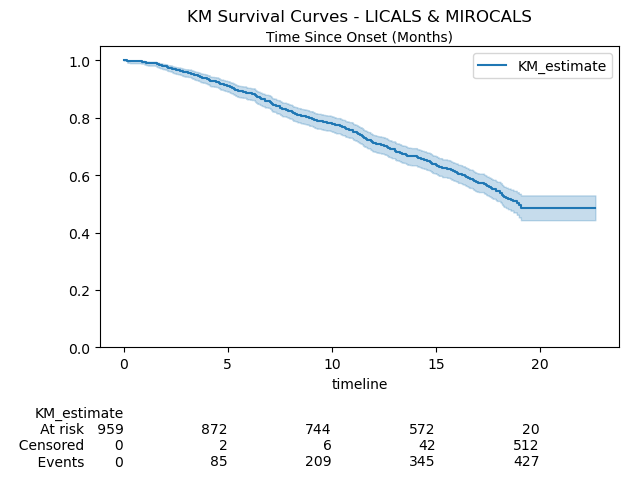

In [372]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df['Disease_Duration'], event_observed = df['Event'])

# kmf.survival_function_.plot()
kmf.plot_survival_function(at_risk_counts = True)
plt.title('KM Survival Curves - LICALS & MIROCALS')
plt.xlabel('Time Since Onset (Months)')
plt.ylabel('Survival Probability')
plt.ylim(0,1.05)
# plt.grid(True)

/var/folders/j8/3lv4xqz91g19302n7m7g_x6c0000gn/T/ipykernel_27308/170623229.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title="Clinical Trials Cluster")


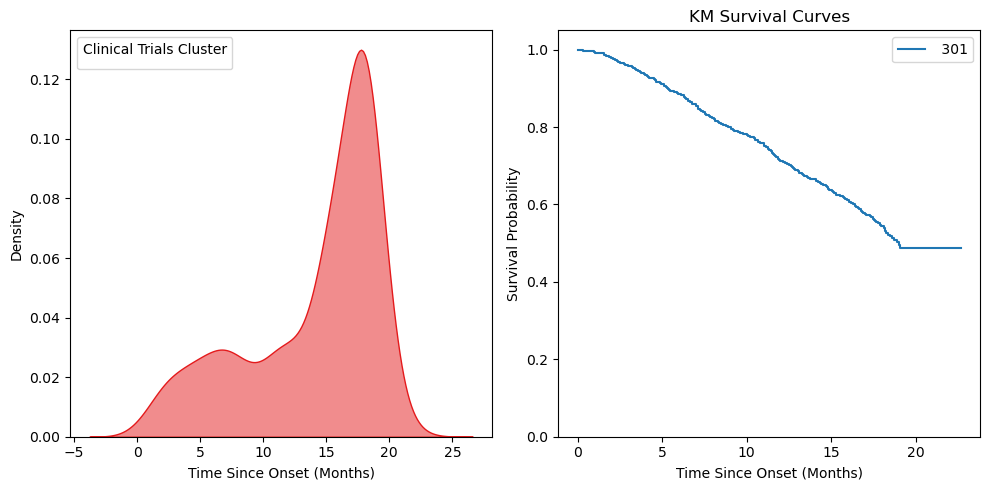

In [373]:
# create side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- Plot 1: KDE plot ---
sns.kdeplot(data=df, x='Disease_Duration', hue='Study_id', fill=True, alpha=0.5, palette='Set1', ax=axes[0])
# axes[0].set_title("Clinical Trials Grouping of Survival Times")
axes[0].set_xlabel("Time Since Onset (Months)")
axes[0].set_ylabel("Density")
axes[0].legend(title="Clinical Trials Cluster")


# --- Plot 2: Kaplan-Meier curves ---
kmf = KaplanMeierFitter()
for group in sorted(df['Study_id'].unique()):
    mask = df['Study_id'] == group
    subset = df.loc[mask, ['Disease_Duration', 'Event']].dropna()
    if subset.empty:
        print(f"Skipping empty group {group}")
        continue
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=f' {group}')
    kmf.plot(ax=axes[1], ci_show=False)  # plot on second subplot

axes[1].set_title("KM Survival Curves")
axes[1].set_xlabel("Time Since Onset (Months)")
axes[1].set_ylabel("Survival Probability")
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

/var/folders/j8/3lv4xqz91g19302n7m7g_x6c0000gn/T/ipykernel_27308/3831278038.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(title="Clinical Trials Cluster")


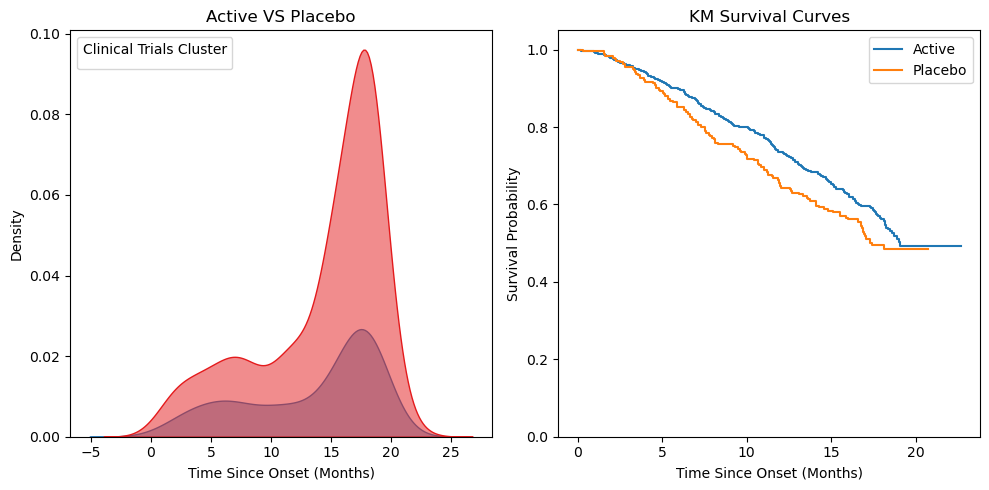

In [374]:
# create side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- Plot 1: KDE plot ---
sns.kdeplot(data=df, x='Disease_Duration', hue='Study_Arm', fill=True, alpha=0.5, palette='Set1', ax=axes[0])
# axes[0].set_title("Clinical Trials Grouping of Survival Times")
axes[0].set_title("Active VS Placebo")
axes[0].set_xlabel("Time Since Onset (Months)")
axes[0].set_ylabel("Density")
axes[0].legend(title="Clinical Trials Cluster")


# --- Plot 2: Kaplan-Meier curves ---
kmf = KaplanMeierFitter()
for group in sorted(df['Study_Arm'].unique()):
    mask = df['Study_Arm'] == group
    subset = df.loc[mask, ['Disease_Duration', 'Event']].dropna()
    if subset.empty:
        print(f"Skipping empty group {group}")
        continue
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=f'{group}')
    kmf.plot(ax=axes[1], ci_show=False)  # plot on second subplot

axes[1].set_title("KM Survival Curves")
axes[1].set_xlabel("Time Since Onset (Months)")
axes[1].set_ylabel("Survival Probability")
axes[1].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

#### **Cox PH**

In [375]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 959 entries, 551 to 1509
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   subject_id                 959 non-null    object 
 1   Event                      959 non-null    int64  
 2   Study_Arm                  959 non-null    object 
 3   Disease_Duration           959 non-null    float64
 4   Expt                       959 non-null    object 
 5   Study_id                   959 non-null    object 
 6   Age                        959 non-null    float64
 7   TRICALS                    959 non-null    float64
 8   Diagnostic Delay           959 non-null    float64
 9   Vital capacity             959 non-null    float64
 10  Onset (Limb)               959 non-null    int64  
 11  European (Yes)             959 non-null    int64  
 12  Sex (Male)                 959 non-null    int64  
 13  Sex (Male) : onset (Limb)  959 non-null    int64  
 

In [376]:
# Identify categorical columns
# cat_cols1 = ['Expt', 'Study_Arm', 'Study_id']  # replace with your actual categorical columns

# # One-hot encode
# df_onehot1 = pd.get_dummies(df, columns=cat_cols1, drop_first=True)
# print(df_onehot1.columns)

# df_onehot1['Study_Arm_Placebo'] = df_onehot1['Study_Arm_Placebo'].astype(int)
# df_onehot1['Expt_mirocals'] = df_onehot1['Expt_mirocals'].astype(int)
# df_onehot1['Study_id_miro'] = df_onehot1['Study_id_miro'].astype(int)

# df_onehot1['Expt_riluzole'] = df_onehot1['Expt_riluzole'].astype(int)
# df_onehot1['Study_id_301'] = df_onehot1['Study_id_301'].astype(int)
# df_onehot1['Study_id_302'] = df_onehot1['Study_id_302'].astype(int)
# df_onehot1['Study_id_lica'] = df_onehot1['Study_id_lica'].astype(int)


In [377]:
df_onehot1 = df.copy()
df_onehot1.head(2)

,subject_id,Event,Study_Arm,Disease_Duration,Expt,Study_id,Age,TRICALS,Diagnostic Delay,Vital capacity,Onset (Limb),European (Yes),Sex (Male),Sex (Male) : onset (Limb),Sex (Male) : Age,Age : onset (Limb),Age : TRICALS
551,11001,1,Active,7.161629,riluzole,301,0.665206,1.189157,0.206982,4.312395,1,1,1,1,64.0,64.0,-126.300009
552,11002,0,Placebo,19.152431,riluzole,301,-1.339438,-1.653300,0.000000,4.848577,1,1,1,1,42.0,42.0,-163.447865


In [378]:
# Train / Test split
print(df_onehot1.shape)

# Separate features from survival info
X = df_onehot1.drop(columns=['Disease_Duration', 'Event'])
y_duration = df_onehot1['Disease_Duration']
y_event = df_onehot1['Event']

# Split
X_train, X_test, y_duration_train, y_duration_test, y_event_train, y_event_test = train_test_split(
    X, y_duration, y_event, test_size=0.2, random_state=4
)

# Combine back for lifelines format
train_df = X_train.copy()
train_df['Disease_Duration'] = y_duration_train
train_df['Event'] = y_event_train

test_df = X_test.copy()
test_df['Disease_Duration'] = y_duration_test
test_df['Event'] = y_event_test

# print(train_df)
# print(test_df)


(959, 17)


In [379]:
print(train_df.shape, test_df.shape)

(767, 17) (192, 17)


In [380]:
from lifelines.utils import concordance_index


def backward_elimination_survival(train_df, test_df, duration_col, event_col, threshold=0.05, verbose=True):
    """
    Perform backward elimination for survival analysis using CoxPH model.

    Parameters
    ----------
    train_df : pd.DataFrame
        Training dataset including features, duration_col, and event_col.
    test_df : pd.DataFrame
        Test dataset including features, duration_col, and event_col.
    duration_col : str
        Name of the duration column.
    event_col : str
        Name of the event indicator column (1=event, 0=censored).
    threshold : float
        p-value threshold for variable removal.
    verbose : bool
        Whether to print progress.

    Returns
    -------
    dict with keys:
        - "final_model": fitted CoxPHFitter object
        - "aic": final model AIC
        - "cindex_train": concordance index on training set
        - "cindex_test": concordance index on test set
        - "selected_variables": list of chosen predictors
    """

    predictors = [col for col in train_df.columns if col not in [duration_col, event_col]]
    
    while True:
        cph = CoxPHFitter()
        cph.fit(train_df[[duration_col, event_col] + predictors], duration_col, event_col)
        
        # Evaluate
        aic = cph.AIC_partial_
        cindex_train = concordance_index(
            train_df[duration_col], -cph.predict_partial_hazard(train_df), train_df[event_col]
        )
        cindex_test = concordance_index(
            test_df[duration_col], -cph.predict_partial_hazard(test_df), test_df[event_col]
        )

        if verbose:
            print("\nModel with variables:", predictors)
            print(f"AIC = {aic:.3f}, Train C-index = {cindex_train:.3f}, Test C-index = {cindex_test:.3f}")

        # Check highest p-value
        summary = cph.summary.sort_values("p")
        worst_pval = summary["p"].max()
        worst_feature = summary["p"].idxmax()

        if worst_pval > threshold:
            if verbose:
                print(f"Removing {worst_feature} (p = {worst_pval:.3f})")
            predictors.remove(worst_feature)
        else:
            break  # stop when all features are significant

    return {
        "final_model": cph,
        "aic": aic,
        "cindex_train": cindex_train,
        "cindex_test": cindex_test,
        "selected_variables": predictors,
    }


In [381]:
df_onehot1.columns

Index(['subject_id', 'Event', 'Study_Arm', 'Disease_Duration', 'Expt',
       'Study_id', 'Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity',
       'Onset (Limb)', 'European (Yes)', 'Sex (Male)',
       'Sex (Male) : onset (Limb)', 'Sex (Male) : Age', 'Age : onset (Limb)',
       'Age : TRICALS'],
      dtype='object')

In [382]:
corr_matrix = df_onehot1.drop(columns=['Disease_Duration', 'Event', 'Study_Arm','Expt', 'Study_id','subject_id']).corr().abs()

high_corr_pairs = []

cols = corr_matrix.columns

for idx_i in range(len(cols)):
    for idx_j in range(idx_i + 1, len(cols)):
        col_i = cols[idx_i]
        col_j = cols[idx_j]
        corr_val = corr_matrix.iloc[idx_i, idx_j]
        if corr_val > 0.95:
            high_corr_pairs.append((col_i, col_j, corr_val))

for a, b, c in high_corr_pairs:
    print(f"{a} — {b}: {c:.3f}")


Sex (Male) — Sex (Male) : Age: 0.950


In [383]:
train_dff = train_df.drop(columns=['subject_id', 'Sex (Male) : Age','Age : TRICALS',
                                    'Study_Arm','Expt', 'Study_id'
       # 'Expt_riluzole', 'Study_Arm_Placebo', 'Study_id_301', 'Study_id_302', 'Study_id_lica', 
       ])

test_dff = test_df.drop(columns=['subject_id', 'Sex (Male) : Age','Age : TRICALS',
                                   'Study_Arm','Expt', 'Study_id'
       # 'Expt_riluzole', 'Study_Arm_Placebo', 'Study_id_301', 'Study_id_302', 'Study_id_lica', 
       ])

In [384]:
train_dff.columns

Index(['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity', 'Onset (Limb)',
       'European (Yes)', 'Sex (Male)', 'Sex (Male) : onset (Limb)',
       'Age : onset (Limb)', 'Disease_Duration', 'Event'],
      dtype='object')

In [385]:
import numpy as np
from sklearn.model_selection import KFold

def surv_kfold_split(df, duration_col, event_col, k=5, random_state=42):
    """
    Correct replacement for lifelines' removed surv_kfold_split.

    - Stratifies on event_col
    - Sorts within strata by duration
    - Returns only valid positional indices (0..n-1), safe for df.iloc[]
    """

    n = len(df)

    # --- Get positional indices ---
    all_idx = np.arange(n)

    event_idx = all_idx[df[event_col].values == 1]
    cens_idx  = all_idx[df[event_col].values == 0]

    # --- Sort by duration to spread times across folds ---
    event_idx = event_idx[np.argsort(df.iloc[event_idx][duration_col])]
    cens_idx  = cens_idx[np.argsort(df.iloc[cens_idx][duration_col])]

    # --- KFold split for each stratum ---
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    event_folds = list(kf.split(event_idx))
    cens_folds  = list(kf.split(cens_idx))

    # --- Combine event + censored folds ---
    for (ev_train_i, ev_test_i), (cs_train_i, cs_test_i) in zip(event_folds, cens_folds):

        train_idx = np.concatenate([
            event_idx[ev_train_i],
            cens_idx[cs_train_i]
        ])

        test_idx = np.concatenate([
            event_idx[ev_test_i],
            cens_idx[cs_test_i]
        ])

        yield train_idx, test_idx


In [386]:

def cv_backward_elimination_survival(
    df,
    duration_col="Disease_Duration",
    event_col="Event",
    k=5,
    threshold=0.05,
    verbose=False
):
    """
    Perform k-fold cross-validation using backward elimination inside each fold.
    """

    fold_results = []
    fold_num = 1

    # surv_kfold_split automatically stratifies by event and duration
    for train_idx, test_idx in surv_kfold_split(df, duration_col=duration_col, event_col=event_col, k=k):

        train_df = df.iloc[train_idx].copy()
        test_df  = df.iloc[test_idx].copy()

        if verbose:
            print("="*60)
            print(f"FOLD {fold_num}")

        # Run backward elimination INSIDE the fold only
        result = backward_elimination_survival(
            train_df=train_df,
            test_df=test_df,
            duration_col=duration_col,
            event_col=event_col,
            threshold=threshold,
            verbose=verbose
        )

        # Evaluate final model on the test fold
        final_model = result["final_model"]
        selected = result["selected_variables"]

        cindex_test_final = concordance_index(
            test_df[duration_col],
            -final_model.predict_partial_hazard(test_df),
            test_df[event_col]
        )

        fold_results.append({
            "fold": fold_num,
            "selected_variables": selected.copy(),
            "cindex_train": result["cindex_train"],
            "cindex_test": cindex_test_final,
            "aic": result["aic"]
        })

        if verbose:
            print(f"Selected variables (fold {fold_num}): {selected}")
            print(f"Final Test C-index (fold {fold_num}): {cindex_test_final:.4f}")

        fold_num += 1

    return fold_results


In [387]:
from lifelines.utils import concordance_index
import numpy as np

results = cv_backward_elimination_survival(
    df=train_dff,
    duration_col="Disease_Duration",
    event_col="Event",
    k=5,
    threshold=0.05,
    verbose=True
)


FOLD 1

Model with variables: ['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity', 'Onset (Limb)', 'European (Yes)', 'Sex (Male)', 'Sex (Male) : onset (Limb)', 'Age : onset (Limb)']
AIC = 2631.080, Train C-index = 0.910, Test C-index = 0.903
Removing Sex (Male) (p = 0.918)

Model with variables: ['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity', 'Onset (Limb)', 'European (Yes)', 'Sex (Male) : onset (Limb)', 'Age : onset (Limb)']
AIC = 2629.091, Train C-index = 0.910, Test C-index = 0.903
Removing Age : onset (Limb) (p = 0.551)

Model with variables: ['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity', 'Onset (Limb)', 'European (Yes)', 'Sex (Male) : onset (Limb)']
AIC = 2627.459, Train C-index = 0.910, Test C-index = 0.903
Removing European (Yes) (p = 0.436)

Model with variables: ['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity', 'Onset (Limb)', 'Sex (Male) : onset (Limb)']
AIC = 2626.128, Train C-index = 0.910, Test C-index = 0.901
Selected variables (fold 1): ['Ag

/opt/anaconda3/envs/digital_twins_2/lib/python3.13/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.735. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


 ['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity', 'Onset (Limb)', 'European (Yes)', 'Sex (Male) : onset (Limb)']
AIC = 2847.893, Train C-index = 0.867, Test C-index = 0.877
Removing Sex (Male) : onset (Limb) (p = 0.380)

Model with variables: ['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity', 'Onset (Limb)', 'European (Yes)']
AIC = 2846.663, Train C-index = 0.866, Test C-index = 0.878
Selected variables (fold 2): ['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity', 'Onset (Limb)', 'European (Yes)']
Final Test C-index (fold 2): 0.8777
FOLD 3

Model with variables: ['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity', 'Onset (Limb)', 'European (Yes)', 'Sex (Male)', 'Sex (Male) : onset (Limb)', 'Age : onset (Limb)']
AIC = 2830.414, Train C-index = 0.869, Test C-index = 0.863
Removing Sex (Male) : onset (Limb) (p = 0.718)

Model with variables: ['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity', 'Onset (Limb)', 'European (Yes)', 'Sex (Male)', 'Age : onset (Limb)']

In [388]:
import pandas as pd

def compute_feature_stability(cv_results):
    """
    Computes how often each variable appears across folds.
    cv_results: list of dicts returned by cv_backward_elimination_survival()
    """

    # Extract selected variables from each fold
    selected_lists = [res["selected_variables"] for res in cv_results]
    all_features = sorted({feat for lst in selected_lists for feat in lst})
    k = len(cv_results)

    # Count frequency
    freq = {feat: sum(feat in lst for lst in selected_lists) for feat in all_features}

    # Convert to DataFrame
    stability_df = pd.DataFrame({
        "feature": list(freq.keys()),
        "selected_in_folds": list(freq.values()),
        "stability_score": [freq[f] / k for f in freq]
    })

    # Sort by stability score
    stability_df = stability_df.sort_values("stability_score", ascending=False)

    return stability_df


In [389]:
stability = compute_feature_stability(results)
stability


,feature,selected_in_folds,stability_score
0,Age,5,1.0
1,Diagnostic Delay,5,1.0
3,Onset (Limb),5,1.0
5,TRICALS,5,1.0
6,Vital capacity,5,1.0
2,European (Yes),2,0.4
4,Sex (Male) : onset (Limb),1,0.2


In [390]:
import matplotlib.pyplot as plt

def plot_feature_stability(stability_df):
    plt.figure(figsize=(8, 5))
    plt.barh(
        stability_df["feature"],
        stability_df["stability_score"]
    )
    plt.xlabel("Stability Score (0–1)")
    plt.title("Feature Stability Across CV Folds")
    plt.gca().invert_yaxis()
    plt.show()


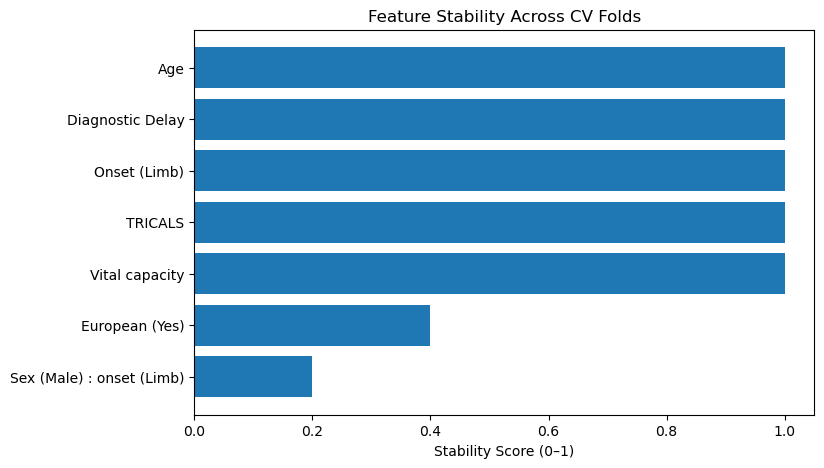

In [391]:
plot_feature_stability(stability)

In [392]:
train_dff.columns

Index(['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity', 'Onset (Limb)',
       'European (Yes)', 'Sex (Male)', 'Sex (Male) : onset (Limb)',
       'Age : onset (Limb)', 'Disease_Duration', 'Event'],
      dtype='object')

In [393]:
backward_elimination_survival(train_df = train_dff, test_df = test_dff, 
                              duration_col = 'Disease_Duration', event_col = 'Event', 
                              threshold=0.05, verbose=False)

{'final_model': <lifelines.CoxPHFitter: fitted with 767 total observations, 428 right-censored observations>,
 'aic': np.float64(3698.5703029793535),
 'cindex_train': np.float64(0.8690279807893089),
 'cindex_test': np.float64(0.841869918699187),
 'selected_variables': ['Age',
  'TRICALS',
  'Diagnostic Delay',
  'Vital capacity',
  'Onset (Limb)',
  'European (Yes)']}

In [394]:
cph = CoxPHFitter()

covars = ['Age', 'Sex (Male)',
  'TRICALS',
  'Diagnostic Delay',
  'Vital capacity',
  'Onset (Limb)',
  'European (Yes)'
  # 'Age : TRICALS'
  ]

cph.fit(train_dff[["Disease_Duration", "Event"] + covars], duration_col="Disease_Duration", event_col="Event")
cph.print_summary()
result = cph.summary.round(2)
result.to_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/CoxPH_riluzole_results.csv')

<lifelines.CoxPHFitter: fitted with 767 total observations, 428 right-censored observations>
             duration col = 'Disease_Duration'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 767
number of events observed = 339
   partial log-likelihood = -1842.83
         time fit was run = 2025-11-24 21:11:22 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Age              -1.13      0.32      0.11           -1.34           -0.92                0.26                0.40
Sex (Male)       -0.11      0.90      0.12           -0.34            0.12                0.71                1.12
TRICALS           2.89     18.01      0.13            2.63            3.15               13.84               23.43
Diagnostic Delay -0.70      0.50      0.09           -0.88           -0.52                0.41                0.59
Vital capacity    1.84      6.27      0.32            1.22            2.46                3.38               11.65
Onset (Limb)      1.85      6.35      0.36            1.14            2.56                3.12               12.93
European (Yes)    0.87      2.40      0.42            0.05            1.70                1.05                5.46

                  cmp to      z      p  -log2(p)
covariate                                       
Age                 0.00 -10.66 <0.005     85.77
Sex (Male)          0.00  -0.95   0.34      1.55
TRICALS             0.00  21.53 <0.005    339.15
Diagnostic Delay    0.00  -7.58 <0.005     44.74
Vital capacity      0.00   5.81 <0.005     27.27
Onset (Limb)        0.00   5.09 <0.005     21.43
European (Yes)      0.00   2.08   0.04      4.73
---
Concordance = 0.87
Partial AIC = 3699.67
log-likelihood ratio test = 573.11 on 7 df
-log2(p) of ll-ratio test = 394.73

Text(0.5, 1.0, 'RIZUZOLE 301')

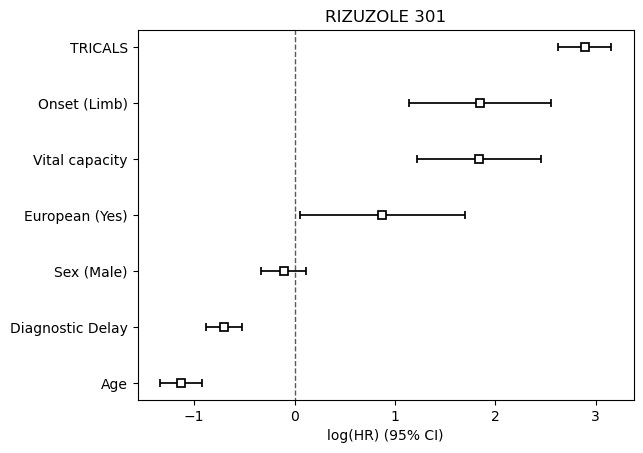

In [395]:
cph.plot()
plt.title("RIZUZOLE 301")

In [396]:
# Check model performance on test set
from lifelines.utils import concordance_index

# Predict partial hazards (risk scores) on test set
test_pred = cph.predict_partial_hazard(test_dff)

# Concordance Index
c_index = concordance_index(
    event_times=test_dff["Disease_Duration"],
    predicted_scores=-test_pred,   # negative, because higher hazard = higher risk
    event_observed=test_dff["Event"]
)

print("C-index on test set:", c_index)

C-index on test set: 0.8412195121951219


In [397]:
train_df.columns

Index(['subject_id', 'Study_Arm', 'Expt', 'Study_id', 'Age', 'TRICALS',
       'Diagnostic Delay', 'Vital capacity', 'Onset (Limb)', 'European (Yes)',
       'Sex (Male)', 'Sex (Male) : onset (Limb)', 'Sex (Male) : Age',
       'Age : onset (Limb)', 'Age : TRICALS', 'Disease_Duration', 'Event'],
      dtype='object')

## ***Compute prognostic score (centered at mean)***

#### ***Training set***

In [398]:
betas = cph.params_
betas

covariate
Age                -1.131850
Sex (Male)         -0.110237
TRICALS             2.891004
Diagnostic Delay   -0.701510
Vital capacity      1.835990
Onset (Limb)        1.847896
European (Yes)      0.873963
Name: coef, dtype: float64

In [399]:
betas = cph.params_

cov_centered = train_dff[betas.index] - train_dff[betas.index].mean()

train_dff['prognostic_score'] = cov_centered.dot(betas)

# Coefficients are in log relative hazard scale, convert to a relative hazard scale
train_dff['relative_hazard'] = np.exp(train_dff['prognostic_score'])

# Categorize prognostic score
train_dff['risk'] = np.where(train_dff['prognostic_score'] < train_dff['prognostic_score'].median(), 'Low risk', 'High risk')

##### ***Compare the KM curves for 'risk' groups***

In [400]:
train_dff.head(2)

,Age,TRICALS,Diagnostic Delay,Vital capacity,Onset (Limb),European (Yes),Sex (Male),Sex (Male) : onset (Limb),Age : onset (Limb),Disease_Duration,Event,prognostic_score,relative_hazard,risk
1118,-2.341761,-2.802998,0.0,4.722242,0,1,1,0,0.0,14.980289,0,-6.712176,0.001216,Low risk
772,0.482966,0.346678,0.0,4.356728,1,0,1,1,62.0,13.042050,1,-0.500762,0.606069,Low risk


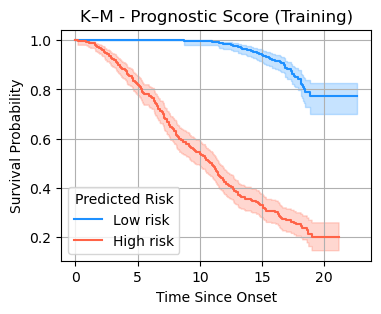

In [401]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(4,3))

color_map = {"High risk": "tomato", "Low risk": "dodgerblue"}

for group in train_dff['risk'].unique():
    mask = train_dff['risk'] == group
    kmf.fit(train_dff['Disease_Duration'][mask], event_observed=train_dff['Event'][mask],
            label=group)
    kmf.plot_survival_function(ci_show=True, color=color_map[group] )      # ← Assign color here)

plt.title("K–M - Prognostic Score (Training)")
plt.xlabel("Time Since Onset")
plt.ylabel("Survival Probability")
plt.legend(title="Predicted Risk")
plt.grid(True)
plt.show()


##### ***Statistical comparison between groups Use the log-rank test from lifelines***

In [402]:
from lifelines.statistics import logrank_test

group0 = train_dff[train_dff["risk"] == 'Low risk']
group1 = train_dff[train_dff["risk"] == 'high risk']

results = logrank_test(group0["Disease_Duration"], group1["Disease_Duration"],
                       event_observed_A=group0["Event"],
                       event_observed_B=group1["Event"])

print(results.summary)


   test_statistic   p  -log2(p)
0             0.0 NaN       NaN


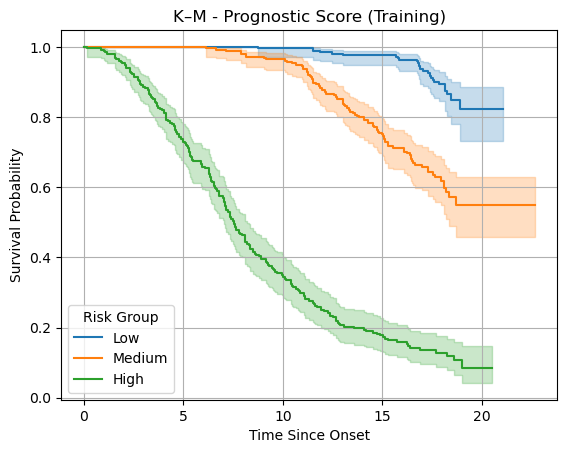

In [403]:
train_dff['risk_group'] = pd.qcut(train_dff['prognostic_score'], 3, labels=['Low','Medium','High'])

for group in ['Low','Medium','High']:
    subset = train_dff[train_dff['risk_group']==group]
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=group)
    kmf.plot_survival_function()
plt.title("K–M - Prognostic Score (Training)")
plt.xlabel("Time Since Onset")
plt.ylabel("Survival Probability")
plt.legend(title="Risk Group")
plt.grid(True)
plt.show()

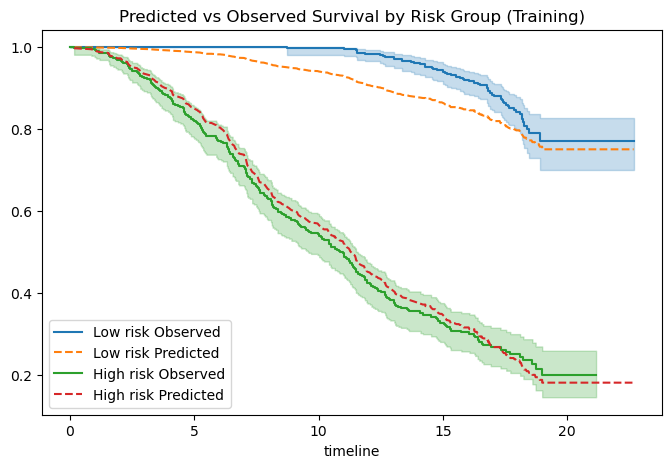

In [404]:
plt.figure(figsize=(8,5))

for group in ['Low risk','High risk']:
    idx = train_dff['risk']==group
    
    # Actual
    kmf.fit(train_dff.loc[idx,'Disease_Duration'], train_dff.loc[idx,'Event'], label=f'{group} Observed')
    kmf.plot_survival_function()
    
    # Predicted
    pred = cph.predict_survival_function(train_dff.loc[idx, betas.index]).mean(axis=1)
    plt.plot(pred.index, pred.values, '--', label=f'{group} Predicted')

plt.legend()
plt.title("Predicted vs Observed Survival by Risk Group (Training)")
plt.show()

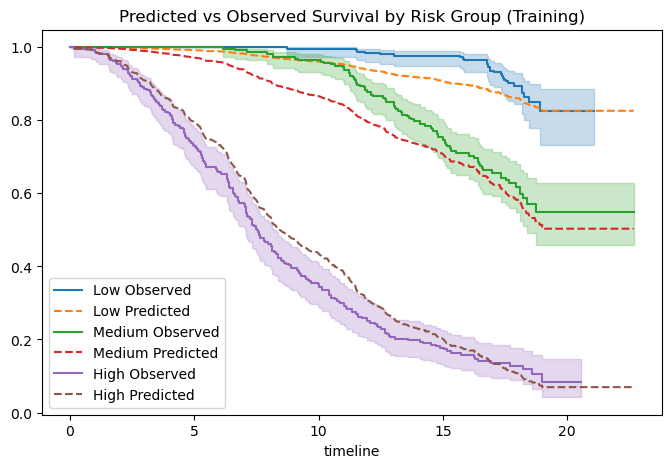

In [405]:
plt.figure(figsize=(8,5))

for group in ['Low','Medium','High']:
    idx = train_dff['risk_group']==group
    
    # Actual
    kmf.fit(train_dff.loc[idx,'Disease_Duration'], train_dff.loc[idx,'Event'], label=f'{group} Observed')
    kmf.plot_survival_function()
    
    # Predicted
    pred = cph.predict_survival_function(train_dff.loc[idx, betas.index]).mean(axis=1)
    plt.plot(pred.index, pred.values, '--', label=f'{group} Predicted')

plt.legend()
plt.title("Predicted vs Observed Survival by Risk Group (Training)")
plt.show()


#### ***Test Set***

In [406]:
# Test set
betas = cph.params_

cov_centered = test_dff[betas.index] - test_dff[betas.index].mean()

test_dff['prognostic_score'] = cov_centered.dot(betas)

# Coefficients are in log relative hazard scale, convert to a relative hazard scale
test_dff['relative_hazard'] = np.exp(test_dff['prognostic_score'])

# Categorize prognostic score
test_dff['risk'] = np.where(test_dff['prognostic_score'] < test_dff['prognostic_score'].median(), 'Low risk', 'High risk')
test_dff.head(2)

,Age,TRICALS,Diagnostic Delay,Vital capacity,Onset (Limb),European (Yes),Sex (Male),Sex (Male) : onset (Limb),Age : onset (Limb),Disease_Duration,Event,prognostic_score,relative_hazard,risk
1179,0.118485,0.112036,0.0,4.342849,1,1,1,1,58.0,15.177398,0,0.199365,1.220627,High risk
1409,-1.430559,-1.104550,0.0,4.320351,1,1,1,1,41.0,16.918528,0,-1.605809,0.200727,Low risk


##### ***Compare the KM curves for 'risk' groups***

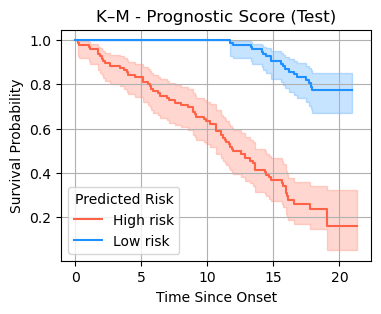

In [407]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(4,3))

color_map = {"High risk": "tomato", "Low risk": "dodgerblue"}

for group in test_dff['risk'].unique():
    mask = test_dff['risk'] == group
    kmf.fit(test_dff['Disease_Duration'][mask], event_observed=test_dff['Event'][mask],
            label=group)
    kmf.plot_survival_function(ci_show=True, color=color_map[group] )      # ← Assign color here)

plt.title("K–M - Prognostic Score (Test)")
plt.xlabel("Time Since Onset")
plt.ylabel("Survival Probability")
plt.legend(title="Predicted Risk")
plt.grid(True)
plt.show()

##### ***Statistical comparison between groups Use the log-rank test from lifelines***

In [408]:
from lifelines.statistics import logrank_test

group0 = test_dff[test_dff["risk"] == 'Low risk']
group1 = test_dff[test_dff["risk"] == 'high risk']

results = logrank_test(group0["Disease_Duration"], group1["Disease_Duration"],
                       event_observed_A=group0["Event"],
                       event_observed_B=group1["Event"])

print(results.summary)


   test_statistic   p  -log2(p)
0             0.0 NaN       NaN


In [409]:
train_dff.shape, test_dff.shape

((767, 15), (192, 14))

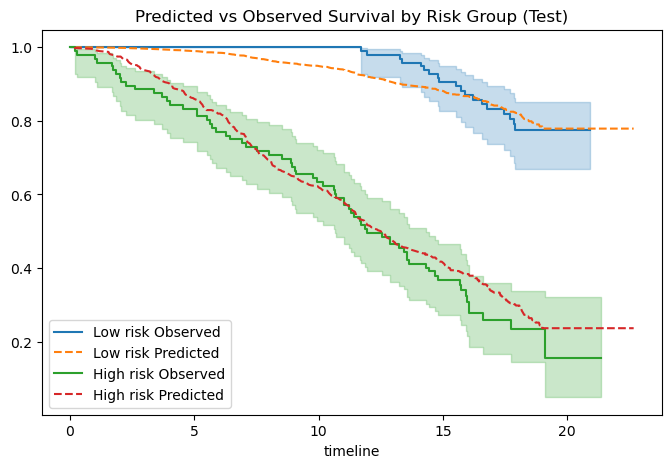

In [410]:
plt.figure(figsize=(8,5))

for group in ['Low risk','High risk']:
    idx = test_dff['risk']==group
    
    # Actual
    kmf.fit(test_dff.loc[idx,'Disease_Duration'], test_dff.loc[idx,'Event'], label=f'{group} Observed')
    kmf.plot_survival_function()
    
    # Predicted
    pred = cph.predict_survival_function(test_dff.loc[idx, betas.index]).mean(axis=1)
    plt.plot(pred.index, pred.values, '--', label=f'{group} Predicted')

plt.legend()
plt.title("Predicted vs Observed Survival by Risk Group (Test)")
plt.show()

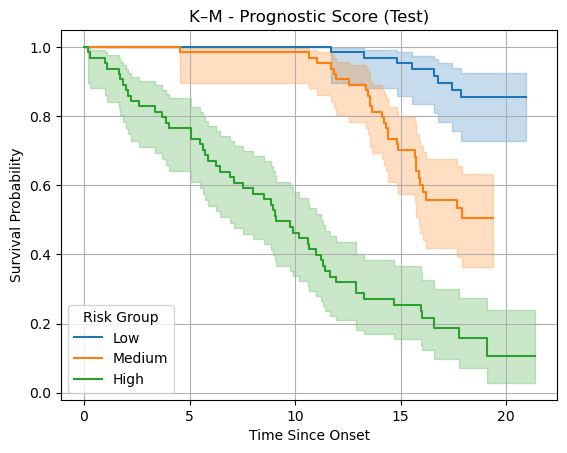

In [411]:
test_dff['risk_group'] = pd.qcut(test_dff['prognostic_score'], 3, labels=['Low','Medium','High'])

for group in ['Low','Medium','High']:
    subset = test_dff[test_dff['risk_group']==group]
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=group)
    kmf.plot_survival_function()
plt.title("K–M - Prognostic Score (Test)")
plt.xlabel("Time Since Onset")
plt.ylabel("Survival Probability")
plt.legend(title="Risk Group")
plt.grid(True)
plt.show()

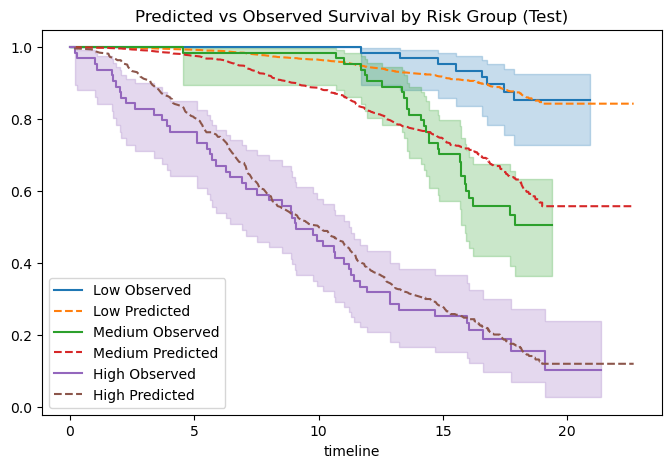

In [412]:
plt.figure(figsize=(8,5))

for group in ['Low','Medium','High']:
    idx = test_dff['risk_group']==group
    
    # Actual
    kmf.fit(test_dff.loc[idx,'Disease_Duration'], test_dff.loc[idx,'Event'], label=f'{group} Observed')
    kmf.plot_survival_function()
    
    # Predicted
    pred = cph.predict_survival_function(test_dff.loc[idx, betas.index]).mean(axis=1)
    plt.plot(pred.index, pred.values, '--', label=f'{group} Predicted')

plt.legend()
plt.title("Predicted vs Observed Survival by Risk Group (Test)")
plt.show()

## ***Estimate Survival Time***

##### ***For training data***

In [413]:

surv_func = cph.predict_survival_function(train_dff[betas.index]) #survival function for each patient

median_survival_time = [] # list to store median survival times
for patient in surv_func.columns:
    surv_curve = surv_func[patient]
    below_half = surv_curve[surv_curve <= 0.5]
    if len(below_half) > 0:
        median_time = below_half.index.min()
    else:
    #     # fall back: take the maximum available time in the grid
        # median_time = surv_curve.median()
        # median_time = surv_curve.min()
        # median_time = surv_curve.index.max()
        median_time = np.nan  # recommended
    median_survival_time.append(median_time)

train_dff['median_survival_time'] = median_survival_time
train_dff.head(2)

# The estimated median survival time answers the question of how long is this patient expected to survive until the chance of being alive falls to 50%?

,Age,TRICALS,Diagnostic Delay,Vital capacity,Onset (Limb),European (Yes),Sex (Male),Sex (Male) : onset (Limb),Age : onset (Limb),Disease_Duration,Event,prognostic_score,relative_hazard,risk,risk_group,median_survival_time
1118,-2.341761,-2.802998,0.0,4.722242,0,1,1,0,0.0,14.980289,0,-6.712176,0.001216,Low risk,Low,NaN
772,0.482966,0.346678,0.0,4.356728,1,0,1,1,62.0,13.042050,1,-0.500762,0.606069,Low risk,Medium,NaN


In [414]:
# # train_dff[['Disease_Duration','median_survival_time']].describe()
# cutoff = train_dff['median_survival_time'].median()

# train_dff['risk_group'] = np.where(
#     train_dff['median_survival_time'] <= cutoff, 'High', 'Low'
# )
# train_dff.risk_group.value_counts().to_dict()

In [415]:
train_dff[['Disease_Duration','median_survival_time']]
train_dff[['Disease_Duration','median_survival_time']].describe()
# train_dff[['Disease_Duration','median_survival_time']].to_dict()

,Disease_Duration,median_survival_time
count,767.000000,375.000000
mean,14.003353,12.157512
std,5.212185,4.679414
min,0.164258,1.051248
25%,10.578187,7.933640
50%,16.261498,12.122208
75%,18.035480,16.819974
max,22.667543,18.988173


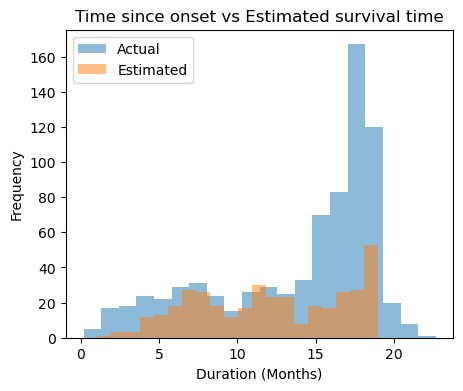

In [416]:
# Compare distributions
plt.figure(figsize=(5,4))
plt.hist(train_dff['Disease_Duration'], bins=20, alpha=0.5, label='Actual')
plt.hist(train_dff['median_survival_time'], bins=20, alpha=0.5, label='Estimated')

plt.xlabel("Duration (Months)")
plt.ylabel("Frequency")
plt.title("Time since onset vs Estimated survival time")
plt.legend()
plt.show()

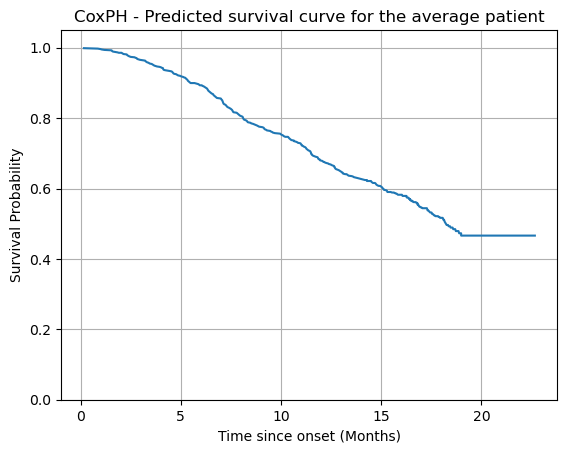

In [417]:
surv = cph.predict_survival_function(train_dff[betas.index]).mean(axis=1)
plt.plot(surv.index, surv.values, label='Predicted')

plt.xlabel("Time since onset (Months)")
plt.title("CoxPH - Predicted survival curve for the average patient")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.ylim(0,1.05)
plt.show()

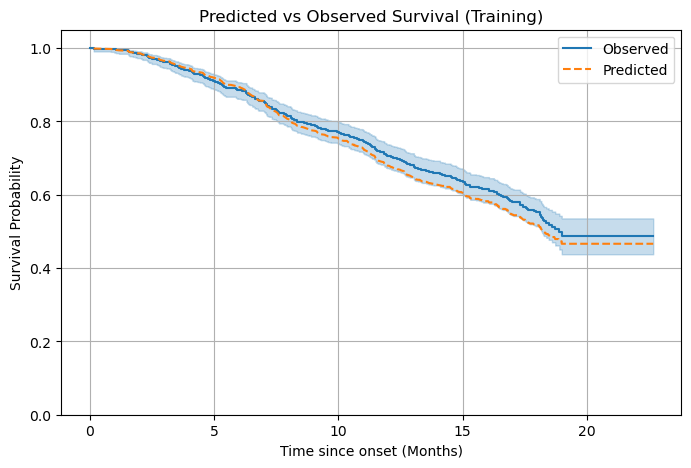

In [418]:
plt.figure(figsize=(8,5))

kmf.fit(train_dff['Disease_Duration'], train_dff['Event'], label=f'Observed')
kmf.plot_survival_function()
    
# Predicted
pred = cph.predict_survival_function(train_dff[betas.index]).mean(axis=1)
plt.plot(pred.index, pred.values, '--', label=f'Predicted')

plt.legend()

plt.title("Predicted vs Observed Survival (Training)")
plt.xlabel("Time since onset (Months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.ylim(0,1.05)
plt.show()

##### ***For test data***

In [419]:
surv_func = cph.predict_survival_function(test_dff[betas.index]) #survival function for each patient

median_survival_time = [] # list to store median survival times
for patient in surv_func.columns:
    surv_curve = surv_func[patient]
    below_half = surv_curve[surv_curve <= 0.5]
    if len(below_half) > 0:
        median_time = below_half.index.min()
    else:
    #     # fall back: take the maximum available time in the grid
        # median_time = surv_curve.median()
        # median_time = surv_curve.min()
        # median_time = surv_curve.index.max()
        median_time = np.nan  # recommended
    median_survival_time.append(median_time)

test_dff['median_survival_time'] = median_survival_time
test_dff.head(2)

,Age,TRICALS,Diagnostic Delay,Vital capacity,Onset (Limb),European (Yes),Sex (Male),Sex (Male) : onset (Limb),Age : onset (Limb),Disease_Duration,Event,prognostic_score,relative_hazard,risk,risk_group,median_survival_time
1179,0.118485,0.112036,0.0,4.342849,1,1,1,1,58.0,15.177398,0,0.199365,1.220627,High risk,Medium,18.889619
1409,-1.430559,-1.104550,0.0,4.320351,1,1,1,1,41.0,16.918528,0,-1.605809,0.200727,Low risk,Low,NaN


In [420]:
# test_dff[['Disease_Duration','median_survival_time']].describe()
# cutoff = test_dff['median_survival_time'].median()

# test_dff['risk_group'] = np.where(
#     test_dff['median_survival_time'] <= cutoff, 'High', 'Low'
# )
# test_dff.risk_group.value_counts().to_dict()


In [421]:
test_dff[['Disease_Duration','median_survival_time']]
test_dff[['Disease_Duration','median_survival_time']].describe()
# test_dff[['Disease_Duration','median_survival_time']].to_dict()

,Disease_Duration,median_survival_time
count,192.000000,87.000000
mean,14.289723,12.854381
std,5.147062,4.858977
min,0.197109,2.890933
25%,11.818331,9.165572
50%,15.867280,14.191853
75%,18.035480,17.214192
max,21.353482,18.988173


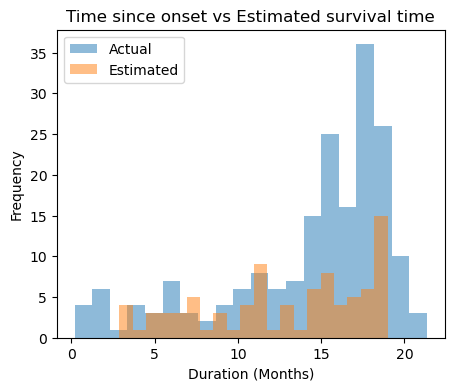

In [422]:
# Compare distributions
plt.figure(figsize=(5,4))
plt.hist(test_dff['Disease_Duration'], bins=20, alpha=0.5, label='Actual')
plt.hist(test_dff['median_survival_time'], bins=20, alpha=0.5, label='Estimated')

plt.xlabel("Duration (Months)")
plt.ylabel("Frequency")
plt.title("Time since onset vs Estimated survival time")
plt.legend()
plt.show()


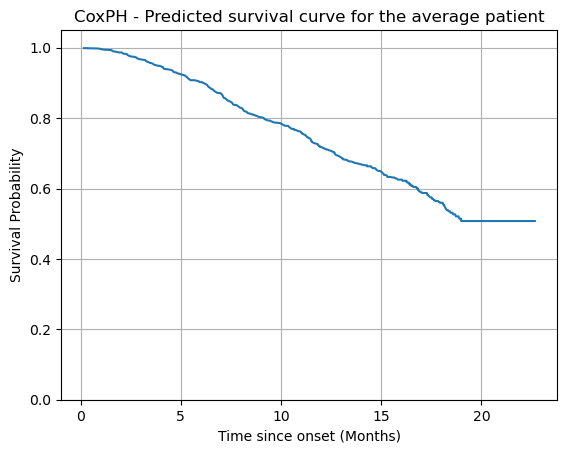

In [423]:
surv = cph.predict_survival_function(test_dff[betas.index]).mean(axis=1)
plt.plot(surv.index, surv.values, label='Predicted')

plt.xlabel("Time since onset (Months)")
plt.title("CoxPH - Predicted survival curve for the average patient")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.ylim(0,1.05)
plt.show()

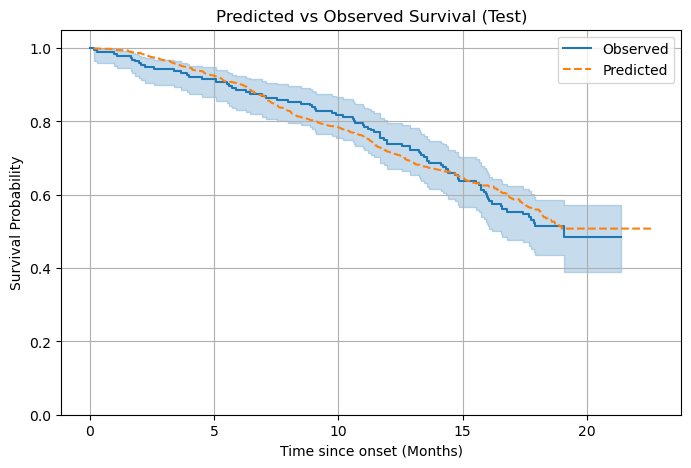

In [424]:
plt.figure(figsize=(8,5))

kmf.fit(test_dff['Disease_Duration'], test_dff['Event'], label=f'Observed')
kmf.plot_survival_function()
    
# Predicted
pred = cph.predict_survival_function(test_dff[betas.index]).mean(axis=1)
plt.plot(pred.index, pred.values, '--', label=f'Predicted')

plt.legend()

plt.title("Predicted vs Observed Survival (Test)")
plt.xlabel("Time since onset (Months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.ylim(0,1.05)
plt.show()

## ***Simulate Virtual Placebo***

In [425]:
df.columns

Index(['subject_id', 'Event', 'Study_Arm', 'Disease_Duration', 'Expt',
       'Study_id', 'Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity',
       'Onset (Limb)', 'European (Yes)', 'Sex (Male)',
       'Sex (Male) : onset (Limb)', 'Sex (Male) : Age', 'Age : onset (Limb)',
       'Age : TRICALS'],
      dtype='object')

In [426]:
print(f"{df.Event.value_counts() / df.Event.value_counts().sum()}\n")
print(f"{df['Onset (Limb)'].value_counts() / df['Onset (Limb)'].value_counts().sum()}\n")
print(f'{df['Sex (Male)'].value_counts() / df['Sex (Male)'].value_counts().sum()}\n')
print(f'{df['European (Yes)'].value_counts() / df['European (Yes)'].value_counts().sum()}\n')
# print(df.Riluzole_use.value_counts() / df.Riluzole_use.value_counts().sum())

print(f'Age: {df['Age'].mean():.2f}, {df['Age'].std():.2f}\n')
print(f'TRICALS: {df['TRICALS'].mean():.2f}, {df['TRICALS'].std():.2f}\n')
# print(f'ALSFRS_Rasch: {df['ALSFRS_Rasch'].mean():.2f}, {df['ALSFRS_Rasch'].std():.2f}')
print(f'Diagnostic Delay: {df['Diagnostic Delay'].mean():.2f}, {df['Diagnostic Delay'].std():.2f}')

Event
0    0.554745
1    0.445255
Name: count, dtype: float64

Onset (Limb)
1    0.954119
0    0.045881
Name: count, dtype: float64

Sex (Male)
1    0.599583
0    0.400417
Name: count, dtype: float64

European (Yes)
1    0.978102
0    0.021898
Name: count, dtype: float64

Age: 0.00, 1.00

TRICALS: 0.00, 1.00

Diagnostic Delay: 0.09, 0.20


In [427]:
betas

covariate
Age                -1.131850
Sex (Male)         -0.110237
TRICALS             2.891004
Diagnostic Delay   -0.701510
Vital capacity      1.835990
Onset (Limb)        1.847896
European (Yes)      0.873963
Name: coef, dtype: float64

In [428]:
ons = df['Onset (Limb)'].value_counts() / df['Onset (Limb)'].value_counts().sum()
sex = df['Sex (Male)'].value_counts() / df['Sex (Male)'].value_counts().sum()
eur = df['European (Yes)'].value_counts() / df['European (Yes)'].value_counts().sum()

In [429]:
# train_dff.shape[0]

In [430]:
corr = train_dff[['Age', 'TRICALS', 'Diagnostic Delay',	'Sex (Male)', 'Onset (Limb)', 'European (Yes)']].corr()
corr

,Age,TRICALS,Diagnostic Delay,Sex (Male),Onset (Limb),European (Yes)
Age,1.000000,0.799170,0.017988,-0.221754,0.055752,0.027624
TRICALS,0.799170,1.000000,0.181585,-0.120456,-0.007891,-0.022250
Diagnostic Delay,0.017988,0.181585,1.000000,-0.024372,0.020021,-0.085269
Sex (Male),-0.221754,-0.120456,-0.024372,1.000000,-0.078204,-0.027640
Onset (Limb),0.055752,-0.007891,0.020021,-0.078204,1.000000,0.005869
European (Yes),0.027624,-0.022250,-0.085269,-0.027640,0.005869,1.000000


In [431]:
from scipy.stats import norm

def gaussian_copula_samples(n, corr):
    """
    Draw correlated U(0,1) samples using a Gaussian copula.
    corr = correlation matrix (p x p).
    Returns: U (n x p) matrix of uniforms.
    """
    L = np.linalg.cholesky(corr)
    Z = np.random.normal(size=(n, corr.shape[0]))
    Z_corr = Z @ L.T
    U = norm.cdf(Z_corr)
    return U


def simulate_cox_dataset(n,baseline='weibull',lam=0.1,rho=1.0,censor_rate=0.3,seed=None,var_specs=None,corr=None):
    """
    Simulate a Cox proportional hazards dataset WITH correlation among covariates
    using a Gaussian copula approach.
    
    Parameters
    ----------
    n : int
        Sample size.
    baseline : {'weibull','exponential'}
    lam : float
        Baseline hazard parameter.
    rho : float
        Weibull shape parameter.
    censor_rate : float
        Desired censoring proportion (approx).
    seed : int or None
    var_specs : list of dicts
        Each dict must include:
            name : str
            type : {'continuous','binary','categorical'}
            and distribution details.
            coef : float or dict (for categorical)
    corr : array-like or None
        Correlation matrix among the variables in var_specs order.
        If None: variables are generated independently.
        
    Returns
    -------
    DataFrame with:
        time, event, true_survival_time, linear_predictor, `<covariates...>`
    """
    
    rng = np.random.default_rng(seed)
    
    if var_specs is None:
        raise ValueError("var_specs must be provided.")

    p = len(var_specs)

    # ----- STEP 1: Generate correlated uniforms -----
    if corr is None:
        U = None
    else:
        corr = np.asarray(corr)
        if corr.shape != (p, p):
            raise ValueError("corr must be p x p with p = len(var_specs)")
        U = gaussian_copula_samples(n, corr)

    # storage
    df = pd.DataFrame(index=np.arange(n))
    linear_pred = np.zeros(n)

    # ----- STEP 2: Generate covariates with correct marginals but correlated -----
    for j, spec in enumerate(var_specs):
        name = spec['name']
        typ = spec['type'].lower()

        # Uniform samples for this variable
        uj = None if U is None else U[:, j]

        # ============================================================
        # CONTINUOUS
        # ============================================================
        if typ == 'continuous':
            dist = spec.get('dist', {'kind': 'normal', 'mean': 0, 'sd': 1})

            if dist['kind'] == 'normal':
                mu = dist.get('mean', 0)
                sd = dist.get('sd', 1)

                if uj is None:
                    x = rng.normal(mu, sd, size=n)
                else:
                    z = norm.ppf(uj)
                    x = mu + sd * z

            elif dist['kind'] == 'uniform':
                lo = dist.get('low', 0)
                hi = dist.get('high', 1)
                if uj is None:
                    x = rng.uniform(lo, hi, size=n)
                else:
                    x = lo + uj * (hi - lo)

            else:
                raise ValueError(f"Unsupported continuous distribution: {dist['kind']}")

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # BINARY
        # ============================================================
        elif typ == 'binary':
            p_bin = float(spec.get('prob', 0.5))

            if uj is None:
                x = rng.binomial(1, p_bin, size=n)
            else:
                x = (uj < p_bin).astype(int)

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # CATEGORICAL
        # ============================================================
        elif typ == 'categorical':
            levels = list(spec['levels'])
            probs = np.asarray(spec.get('probs', [1 / len(levels)] * len(levels)))

            # boundaries for inverse-CDF categories
            cum = np.cumsum(probs)

            if uj is None:
                cats = rng.choice(levels, p=probs, size=n)
            else:
                # Assign category by uniform bins
                cats = np.empty(n, dtype=object)
                for k, lvl in enumerate(levels):
                    if k == 0:
                        mask = uj <= cum[k]
                    else:
                        mask = (uj > cum[k - 1]) & (uj <= cum[k])
                    cats[mask] = lvl

            df[name] = pd.Categorical(cats, categories=levels)

            # Add to linear predictor
            coef_map = spec.get('coef', {})
            ref = spec.get('ref', levels[0])
            for lvl in levels:
                if lvl == ref:
                    continue
                coef_lvl = float(coef_map.get(lvl, 0.0))
                linear_pred += coef_lvl * (cats == lvl)

        else:
            raise ValueError(f"Unsupported variable type: {typ}")

    # ----- STEP 3: Generate survival times -----
    U_time = rng.uniform(size=n)

    if baseline == 'exponential' or rho == 1.0:
        T = -np.log(U_time) / (lam * np.exp(linear_pred))
    elif baseline == 'weibull':
        # Weibull inverse CDF: T = (-log U)^(1/rho) / (lam*exp(lp))^(1/rho)
        T = (-np.log(U_time)) ** (1.0 / rho) / (lam * np.exp(linear_pred)) ** (1.0 / rho)
    else:
        raise ValueError("baseline must be 'exponential' or 'weibull'")

    # ----- STEP 4: Generate censoring -----
    # heuristic to reach the target censoring proportion
    scale_c = max(1e-6, T.mean() * censor_rate / (1 - censor_rate + 1e-9))
    C = rng.exponential(scale=scale_c, size=n)

    observed_time = np.minimum(T, C)
    event = (T <= C).astype(int)

    # ----- STEP 5: Build output -----
    df['time'] = observed_time
    df['event'] = event
    df['true_survival_time'] = T
    df['linear_predictor'] = linear_pred

    cols = ['time', 'event', 'true_survival_time', 'linear_predictor']
    cols += [c for c in df.columns if c not in cols]
    df = df[cols]

    return df


In [432]:
var_specs_real = [
    # continuous
    {'name':'Age','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':betas['Age']},
    {'name':'TRICALS','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':betas['TRICALS']},
    {'name':'Diagnostic Delay','type':'continuous','dist':{'kind':'normal','mean':df['Diagnostic Delay'].mean(),
                                                           'sd':df['Diagnostic Delay'].std()},
                                                           'coef':betas['Diagnostic Delay']},
    {'name':'Vital capacity','type':'continuous','dist':{'kind':'normal','mean':df['Vital capacity'].mean(),
                                                           'sd':df['Vital capacity'].std()},
                                                           'coef':betas['Vital capacity']},

    # binary
    {'name':'Sex (Male)','type':'binary','prob':sex[1],'coef':betas['Sex (Male)']},
    {'name':'Onset (Limb)','type':'binary','prob':ons[1],'coef':betas['Onset (Limb)']},
    {'name':'European (Yes)','type':'binary','prob':eur[1],'coef':betas['European (Yes)']}
    
    # # categorical
    # {'name':'Onset_site','type':'categorical',
    #  'levels':['bulbar','limb','other'],'probs':[0.218484,0.746833,0.034683],
    #  'coef':{'limb':1.151159,'other':2.508786},'ref':'bulbar'}
    
    # interactions not included yet!
]

corr = train_dff[['Age', 'TRICALS', 'Diagnostic Delay','Sex (Male)','Vital capacity', 'Onset (Limb)', 'European (Yes)']].corr()

df_sim = simulate_cox_dataset(n=train_dff.shape[0], baseline='weibull', lam=0.01, rho=1.5, 
                              censor_rate=0.3, seed=42, corr=corr, var_specs=var_specs_real)


df_sim.head(3)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic Delay,Vital capacity,Sex (Male),Onset (Limb),European (Yes)
0,0.001836,0,0.002657,12.139174,0.438168,0.375180,-0.159696,4.747619,0,1,1
1,0.002795,0,0.004934,12.378391,-0.137097,0.545607,0.298624,4.430032,0,1,1
2,0.001635,1,0.001635,12.348629,1.649612,1.622949,-0.018607,4.173684,0,1,0


In [433]:
sim_onehot = df_sim
sim_onehot.head(3)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic Delay,Vital capacity,Sex (Male),Onset (Limb),European (Yes)
0,0.001836,0,0.002657,12.139174,0.438168,0.375180,-0.159696,4.747619,0,1,1
1,0.002795,0,0.004934,12.378391,-0.137097,0.545607,0.298624,4.430032,0,1,1
2,0.001635,1,0.001635,12.348629,1.649612,1.622949,-0.018607,4.173684,0,1,0


##### 4. Compare Cox model coefficients

In [434]:
sim_onehot.columns

Index(['time', 'event', 'true_survival_time', 'linear_predictor', 'Age',
       'TRICALS', 'Diagnostic Delay', 'Vital capacity', 'Sex (Male)',
       'Onset (Limb)', 'European (Yes)'],
      dtype='object')

In [435]:
sim_onehot1 = sim_onehot.copy()
sim_onehot1['Sex (Male) : onset (Limb)'] = sim_onehot1['Sex (Male)'] * sim_onehot1['Onset (Limb)'] 
# sim_onehot1['Sex_onset_limb'] = sim_onehot1['Sex']*sim_onehot1['Onset_site']
# sim_onehot1['Age_onset_limb'] = sim_onehot1['Age']*sim_onehot1['Onset_site']

sim_onehot1.head(2)

,time,event,true_survival_time,linear_predictor,Age,TRICALS,Diagnostic Delay,Vital capacity,Sex (Male),Onset (Limb),European (Yes),Sex (Male) : onset (Limb)
0,0.001836,0,0.002657,12.139174,0.438168,0.375180,-0.159696,4.747619,0,1,1,0
1,0.002795,0,0.004934,12.378391,-0.137097,0.545607,0.298624,4.430032,0,1,1,0


In [436]:
# Train / Test split

# Separate features from survival info
X = sim_onehot1.drop(columns=['time', 'true_survival_time', 'event', 'linear_predictor'])
y_duration = sim_onehot1['time']
y_event = sim_onehot1['event']

# Split
X_train, X_test, y_duration_train, y_duration_test, y_event_train, y_event_test = train_test_split(
    X, y_duration, y_event, test_size=0.2, random_state=4
)

# Combine back for lifelines format
simtrain_df = X_train.copy()
simtrain_df['time'] = y_duration_train
simtrain_df['event'] = y_event_train

simtest_df = X_test.copy()
simtest_df['time'] = y_duration_test
simtest_df['event'] = y_event_test

# print(train_df)
# print(test_df)

In [437]:
# simtrain_df.corr().abs()

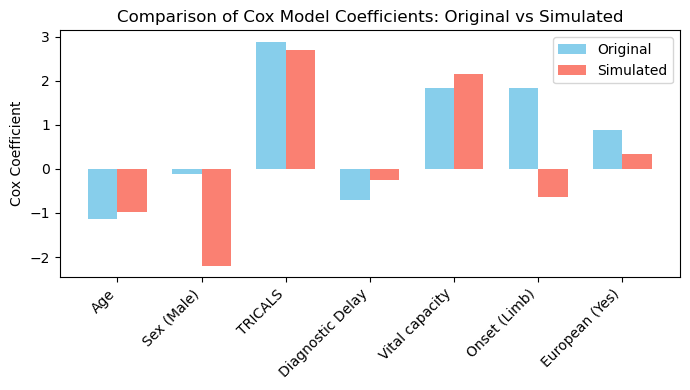

In [438]:
# Fit Cox on simulated data
cph_sim = CoxPHFitter()
cph_sim.fit(simtrain_df, duration_col="time", event_col="event")

# Extract coefficients
coeff_orig = cph.params_
coeff_sim = cph_sim.params_

# Align indices (covariates) in case of any mismatch
common_idx = coeff_orig.index.intersection(coeff_sim.index)
coeff_orig = coeff_orig[common_idx]
coeff_sim = coeff_sim[common_idx]

# Plot
x = np.arange(len(common_idx))
width = 0.35

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(x - width/2, coeff_orig.values, width, label='Original', color='skyblue')
ax.bar(x + width/2, coeff_sim.values, width, label='Simulated', color='salmon')

ax.set_xticks(x)
ax.set_xticklabels(common_idx, rotation=45, ha='right')
ax.set_ylabel('Cox Coefficient')
ax.set_title('Comparison of Cox Model Coefficients: Original vs Simulated')
ax.legend()
plt.tight_layout()
plt.show()

In [439]:
coeff_sim

covariate
Age                -0.985637
Sex (Male)         -2.199497
TRICALS             2.696822
Diagnostic Delay   -0.250277
Vital capacity      2.145244
Onset (Limb)       -0.637244
European (Yes)      0.332337
Name: coef, dtype: float64

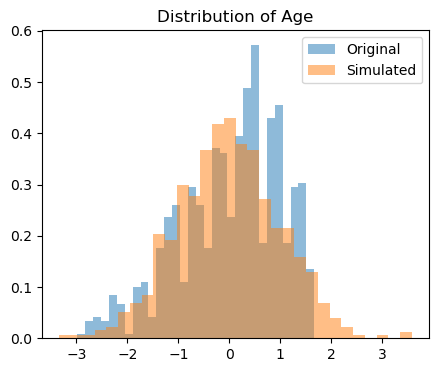

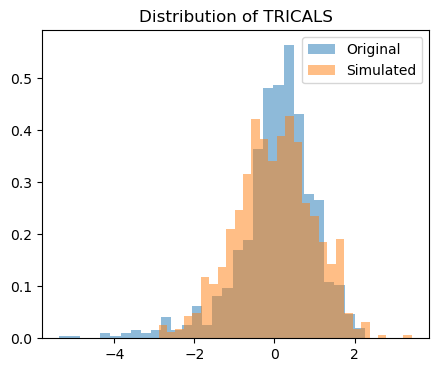

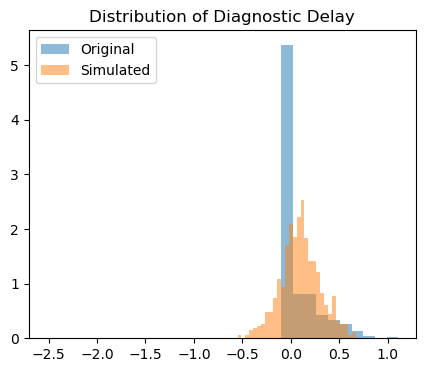

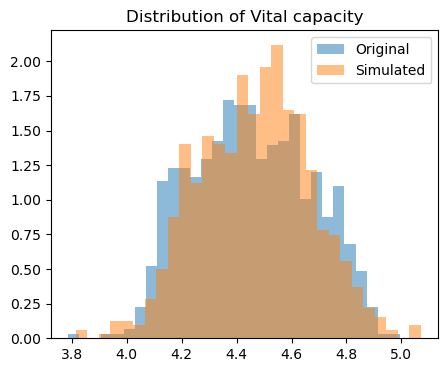

In [440]:
for col in ['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity']:  # replace with your continuous columns
    plt.figure(figsize=(5,4))
    plt.hist(train_df[col], bins=30, alpha=0.5, label='Original', density=True)
    plt.hist(sim_onehot[col], bins=30, alpha=0.5, label='Simulated', density=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()

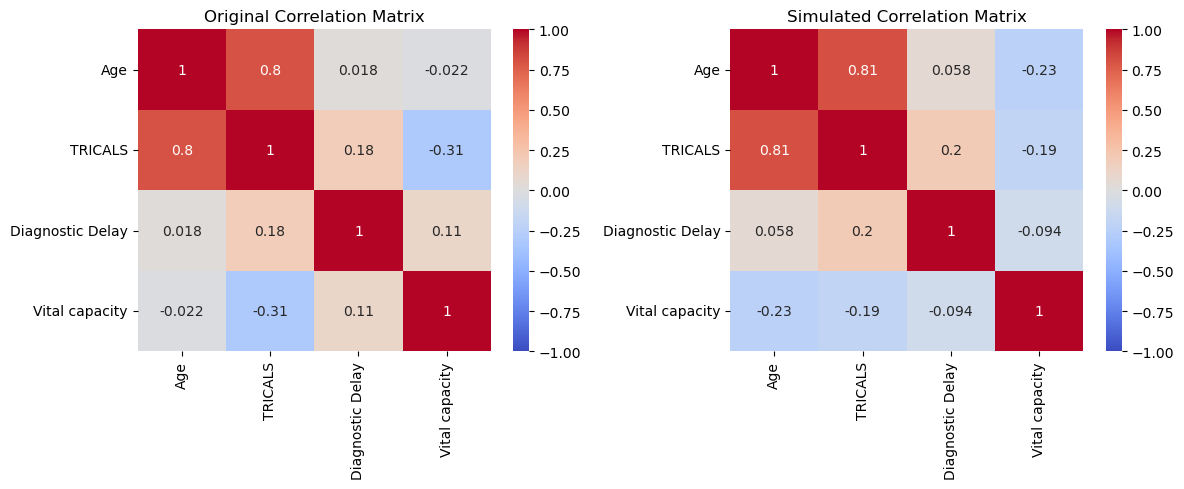

In [441]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity']

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Original correlation
sns.heatmap(train_dff[cols].corr(), annot=True, cmap="coolwarm", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Original Correlation Matrix")

# Simulated correlation
sns.heatmap(sim_onehot[cols].corr(), annot=True, cmap="coolwarm", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Simulated Correlation Matrix")

plt.tight_layout()
plt.show()

In [442]:
from scipy.stats import ttest_ind

for col in ['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity']:
    
    # Extract samples
    original = train_dff[col].dropna()
    simulated = sim_onehot[col].dropna()
    
    # Two-sample Welch t-test (recommended)
    t_stat, p_val = ttest_ind(original, simulated, equal_var=False)
    
    print(f"\nT-test for {col}:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value:     {p_val:.4g}")



T-test for Age:
  t-statistic: 0.5807
  p-value:     0.5616

T-test for TRICALS:
  t-statistic: 0.4043
  p-value:     0.6861

T-test for Diagnostic Delay:
  t-statistic: -0.3608
  p-value:     0.7183

T-test for Vital capacity:
  t-statistic: -1.1040
  p-value:     0.2698


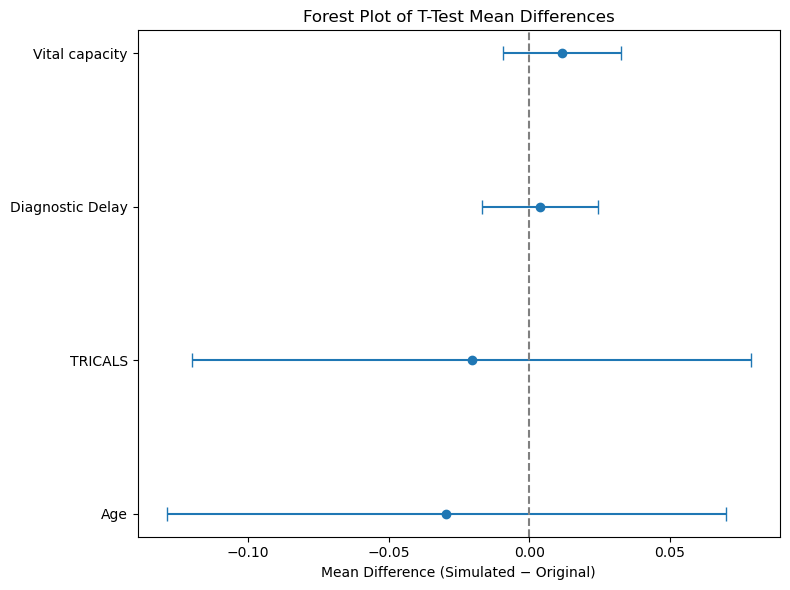

In [443]:
from scipy.stats import ttest_ind

cols = ['Age', 'TRICALS', 'Diagnostic Delay', 'Vital capacity']

results = []

for col in cols:
    original = train_dff[col].dropna()
    simulated = sim_onehot[col].dropna()

    # Welch t-test
    t_stat, p_val = ttest_ind(original, simulated, equal_var=False)

    # Mean difference
    mean_diff = simulated.mean() - original.mean()

    # Standard errors for CI (Welch)
    se = np.sqrt(original.var()/len(original) + simulated.var()/len(simulated))

    # 95% CI
    ci_low = mean_diff - 1.96 * se
    ci_high = mean_diff + 1.96 * se

    results.append([col, mean_diff, ci_low, ci_high, p_val])

df_plot = pd.DataFrame(results, columns=["Variable", "MeanDiff", "CI_low", "CI_high", "p_value"])


# --------- Forest Plot ---------
plt.figure(figsize=(8, 6))

y_pos = np.arange(len(df_plot))

plt.errorbar(
    df_plot["MeanDiff"], 
    y_pos, 
    xerr=[df_plot["MeanDiff"] - df_plot["CI_low"], df_plot["CI_high"] - df_plot["MeanDiff"]],
    fmt='o', 
    capsize=5
)

plt.axvline(0, color='gray', linestyle='--')

plt.yticks(y_pos, df_plot["Variable"])
plt.xlabel("Mean Difference (Simulated − Original)")
plt.title("Forest Plot of T-Test Mean Differences")

plt.tight_layout()
plt.show()
